In [1]:
%pip install pandas
%pip install matplotlib
%pip install torch
%pip install torchtext
%pip install nltk
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import gzip
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/519 Project/Data'

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

#gift_card_path = os.path.join(path, 'Gift_Cards_5.json.gz')
#df = getDF(gift_card_path)

electronics_aws_path = 'electronics_downsampled_pos_neg_binary.csv'

#electronics_path = os.path.join(path, 'electronics_downsampled_pos_neg_binary.csv')
df = pd.read_csv(electronics_aws_path, low_memory = False)

In [4]:
#preprocessing

#TODO: add in Dan's preprocessing code
df = df[['reviewText', 'pos_neg']]
df = df.rename(columns = {'pos_neg': 'overall'})

#df = df[['reviewText', 'overall']]
df = df[df['reviewText'].notna()]
print(df.columns)
print('hi')

#from spell_check import fixSentence
#df['reviewText'] = df['reviewText'].apply(lambda x: fixSentence(x))

#print('CHECKPOINT: Spell Check Complete')

Index(['reviewText', 'overall'], dtype='object')
hi


In [5]:
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

def tokenize(sentence):
  tokens = token.tokenize(sentence)
  filtered = [x for x in tokens if not x in stop_words]
  return filtered

df['tokenized'] = df['reviewText'].apply(tokenize)
df = df[['tokenized', 'overall']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#df['overall_adj'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)
#df = df[['tokenized', 'overall_adj']]
#df = df.rename(columns = {'overall_adj': 'overall'})

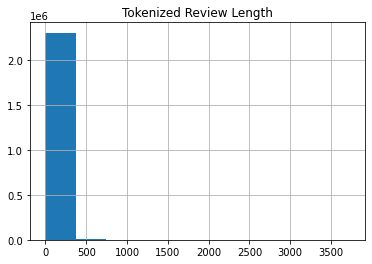

In [6]:
len_tokens = [len(i) for i in df['tokenized']]
pd.Series(len_tokens).hist()
plt.title('Tokenized Review Length')
plt.show()
pd.Series(len_tokens).describe()

df['len'] = df['tokenized'].apply(lambda x: len(x))
df = df.loc[df['len'] >= 4]

In [7]:
from sklearn.model_selection import train_test_split

print('starting split')
train_df, test_df = train_test_split(df, test_size = .2, random_state = 42)

print('done split')
train_json = train_df.to_json(orient = 'records')
train_json_result = json.loads(train_json)
with open('sample_data/train_gift_cards.json', 'w') as f:
  for entry in train_json_result:
    json.dump(entry, f)
    f.write('\n')

print('done writing train')
test_json = test_df.to_json(orient = 'records')
test_json_result = json.loads(test_json)
with open('sample_data/test_gift_cards.json', 'w') as f:
  for entry in test_json_result:
    json.dump(entry, f)
    f.write('\n')

print('done writing test')

starting split
done split
done writing train
done writing test


In [ ]:
MAX_LEN = 277

In [8]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets


TOKENS = data.Field(lower = True, batch_first = True)
SCORE = data.LabelField(dtype = torch.float)

fields = {'tokenized': ('tokens', TOKENS), 'overall': ('score', SCORE)}
train_data, test_data = data.TabularDataset.splits(
    path = 'sample_data',
    train = 'train_gift_cards.json',
    test = 'test_gift_cards.json',
    format = 'json',
    fields = fields
)
print(vars(train_data[0]))

{'tokens': ['when', 'i', 'first', 'got', 'i', 'set', 'upstairs', 'bedroom', 'connected', 'tv', 'get', 'angle', 'right', 'away', 'i', 'got', 'something', 'like', '11', 'channels', 'mind', 'inside', 'house', 'pointing', 'kids', 'bathroom', 'another', 'bedroom', 'finally', 'side', 'house', 'trees', 'most', 'channels', 'wanted', 'i', 'got', 'way', 'turns', 'angle', 'really', 'issue', 'channels', 'area', 'grouped', 'pretty', 'close', 'when', 'mounted', 'attic', 'i', 'able', 'point', 'angle', 'i', 'wanted', 'i', 'mounted', 'i', 'slightly', 'worried', 'i', 'find', 'different', 'location', 'when', 'i', 'plugged', 'tv', 'search', 'channels', '18', 'channels', 'including', 'pbs', 'vhf', 'i', 'seattle', 'area', 'north', 'around', 'mill', 'creek', 'good', 'signals', 'channels', 'the', 'ion', 'channels', 'last', 'channels', 'get', 'i', 'find', 'sometimes', 'best', 'signal', 'we', 'see', 'happens', 'winter', 'far', 'big', 'disruptions', 'with', 'roku', 'xbox', 'netflix', 'hulu', 'i', 'say', 'goodbye

In [9]:
TOKENS.build_vocab(train_data, 
                   max_size = 10000,
                   vectors = "glove.6B.100d", 
                   unk_init = torch.Tensor.normal_)
SCORE.build_vocab(train_data)

print('done building vocab')

.vector_cache/glove.6B.zip: 862MB [02:46, 5.19MB/s]                               
100%|█████████▉| 399999/400000 [00:16<00:00, 24790.02it/s]


done building vocab


In [10]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(train_data, sort_key = lambda x: x.tokens, 
                                     sort = False, sort_within_batch = True, batch_size= 32, device = device)
test_iterator = data.BucketIterator(test_data, sort_key = lambda x: x.tokens, 
                                    sort = False, sort_within_batch = True, batch_size= 1, device = device)
print('done making iterators')

done making iterators


In [11]:
'''
model architecture taken from: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb
'''
import torch.nn as nn
import torch.nn.functional as F

class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).unsqueeze(1)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

In [12]:
input_dim = len(TOKENS.vocab)
embedding_dim = 100
n_filters = 100
filter_sizes = [1,2,3,4]
output_dim = 1
dropout = .5
pad_idx = TOKENS.vocab.stoi[TOKENS.pad_token]

model = CNN_Text(input_dim, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

In [13]:
pretrained_embeddings = TOKENS.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

unk_idx = TOKENS.vocab.stoi[TOKENS.unk_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

In [14]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [20]:
"""
Basic train loop for cnn
"""
def train_cnn(model, iterator, optimizer, criterion, epochs=10):
    print('start reached')
    for child in model.children():
        if hasattr(child, 'reset_parameters'):
            child.reset_parameters()
    
    model = model.to(device)
    model.train()

    accuracy_list = []
    loss_list = []
    print('starting training')
    for epoch in range(epochs):
        epoch_acc = 0
        epoch_loss = 0
        for batch in iterator:
            optimizer.zero_grad()
            outputs = model(batch.tokens).squeeze(1)
            
            loss = criterion(outputs, batch.score)
            
            epoch_acc += binary_accuracy(outputs, batch.score).item()
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        epoch_acc = epoch_acc / len(iterator)
        epoch_loss = epoch_loss / len(iterator)
        accuracy_list.append(epoch_acc)
        loss_list.append(epoch_loss)
        print('Epoch Num: %d, Accuracy: %.4f, Loss: %.4f' % (epoch + 1, epoch_acc, epoch_loss))

    final_training_accuracy = accuracy_list[-1]     
    final_training_loss = loss_list[-1]
    return final_training_accuracy, final_training_loss

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

train_cnn(model, train_iterator, optimizer, criterion)
print('done')

start reached
starting training
